In [22]:
import os
import pandas as pd
import numpy as np

# Directories for the experiment results
geneformer_base_dir = "/home/igor/igor_repos/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/analysis/outputs/2025-12-07_23-21_evaluate_all_shendure_geneformer_models_on_mid_quality_data"
scvi_base_dir = "/home/igor/igor_repos/noise_scaling_laws/Scaling-up-measurement-noise-scaling-laws/analysis/outputs/2025-12-08_22-15_reeval_scvis"

# The dataset, size, and relevant signals
experiment_configs = {
    "shendure": (10000000,
                 [1.0, 0.5414548, 0.2931733, 0.1587401, 0.0859506, 0.0465384, 0.0251984, 0.0136438, 0.0073875, 0.004],
                 ["author_day"])
}

algorithms = ["Geneformer", "SCVI"]

records = []

for dataset, (size, bvalues, signals) in experiment_configs.items():
    for bvalue in bvalues:
        for signal in signals:
            seed = 42
            for algo in algorithms:
                if algo == "Geneformer":
                    # For Geneformer, use original output directory and path structure
                    base_dir = geneformer_base_dir
                    # Standard path for Geneformer LMI output
                    path_original = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_{bvalue}_{algo.lower()}"
                    file_original = os.path.join(path_original, "lmi_mutual_information.txt")
                    path_high_quality_eval = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_1.0_{algo.lower()}"
                    file_high_quality_eval = os.path.join(path_high_quality_eval, "lmi_mutual_information.txt")
                elif algo == "SCVI":
                    # For SCVI, use the output directory instructed in the prompt
                    base_dir = scvi_base_dir
                    path_original = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_{bvalue}"
                    file_original = os.path.join(path_original, "lmi_mutual_information.txt")
                    path_high_quality_eval = f"{base_dir}/{dataset}/{size}/{bvalue}/results/{algo}/model/MI/{seed}/Y_{signal}_1.0"
                    file_high_quality_eval = os.path.join(path_high_quality_eval, "lmi_mutual_information.txt")
                else:
                    continue

                # lmi evaluated on variable quality (bvalue)
                if os.path.exists(file_original):
                    try:
                        with open(file_original, "r") as f:
                            lmi_original_same_quality_eval = f.read().strip()
                    except Exception:
                        lmi_original_same_quality_eval = None
                else:
                    lmi_original_same_quality_eval = None

                # lmi evaluated on HIGH quality (bvalue=1.0), model trained on bvalue quality
                if os.path.exists(file_high_quality_eval):
                    try:
                        with open(file_high_quality_eval, "r") as f:
                            lmi_new_high_quality_eval = f.read().strip()
                    except Exception:
                        lmi_new_high_quality_eval = None
                else:
                    lmi_new_high_quality_eval = None

                records.append({
                    "dataset": dataset,
                    "size": size,
                    "bvalue": bvalue,
                    "signal": signal,
                    "algorithm": algo,
                    "seed": seed,
                    "lmi_new_high_quality_eval": lmi_new_high_quality_eval,
                    "lmi_original_same_quality_eval": lmi_original_same_quality_eval
                })

mi_fs_df = pd.DataFrame(records)

if 'seed' in mi_fs_df.columns:
    mi_fs_df = mi_fs_df.drop(columns=['seed'])
if 'umis_per_cell' in mi_fs_df.columns:
    mi_fs_df = mi_fs_df.drop(columns=['umis_per_cell'])

# If you have a CSV or other result to compare, load it here (or set mi_csv_df to an empty df if not available)
mi_csv_df = pd.DataFrame()
# Optionally, if you want to compare to a previous CSV, you can load it like this:
# mi_csv_df = pd.read_csv("/path/to/previous_results.csv")
# mi_csv_df = mi_csv_df.rename(columns={'quality': 'bvalue'})

# Type cast for merging
mi_fs_df['signal'] = mi_fs_df['signal'].astype(str)
mi_fs_df['algorithm'] = mi_fs_df['algorithm'].astype(str)
if not mi_csv_df.empty:
    mi_csv_df['signal'] = mi_csv_df['signal'].astype(str)
    mi_csv_df['algorithm'] = mi_csv_df['algorithm'].astype(str)

# Merge if applicable
if not mi_csv_df.empty:
    merged_df = pd.merge(
        mi_fs_df,
        mi_csv_df,
        how='left',
        on=['dataset', 'size', 'bvalue', 'signal', 'algorithm'],
        suffixes=('', '_csv')
    )
else:
    merged_df = mi_fs_df

# Convert to numeric to standardize "None" and empty strings to np.nan
merged_df['lmi_new_high_quality_eval'] = pd.to_numeric(merged_df['lmi_new_high_quality_eval'], errors='coerce')
merged_df['lmi_original_same_quality_eval'] = pd.to_numeric(merged_df['lmi_original_same_quality_eval'], errors='coerce')

# DO NOT drop rows with NaN in the LMI columns; keep all rows.
merged_df

# Add missing SCVI row with lmi_new_high_quality_eval and lmi_original_same_quality_eval = 2.44841 at bvalue=1.0
mask = (
    (merged_df['dataset'] == "shendure") & 
    (merged_df['size'] == 10000000) & 
    (merged_df['bvalue'] == 1.0) &
    (merged_df['signal'] == "author_day") & 
    (merged_df['algorithm'] == "SCVI")
)
merged_df.loc[mask, 'lmi_new_high_quality_eval'] = 2.44841
merged_df.loc[mask, 'lmi_original_same_quality_eval'] = 2.44841
merged_df

,dataset,size,bvalue,signal,algorithm,lmi_new_high_quality_eval,lmi_original_same_quality_eval
0,shendure,10000000,1.000000,author_day,Geneformer,1.92699,1.92699
1,shendure,10000000,1.000000,author_day,SCVI,2.44841,2.44841
2,shendure,10000000,0.541455,author_day,Geneformer,1.85850,1.79979
3,shendure,10000000,0.541455,author_day,SCVI,NaN,NaN
4,shendure,10000000,0.293173,author_day,Geneformer,2.05358,2.01080
5,shendure,10000000,0.293173,author_day,SCVI,2.38989,2.23359
6,shendure,10000000,0.158740,author_day,Geneformer,1.89000,1.90433
7,shendure,10000000,0.158740,author_day,SCVI,2.30624,1.99694
8,shendure,10000000,0.085951,author_day,Geneformer,1.77112,1.73928
9,shendure,10000000,0.085951,author_day,SCVI,2.21306,1.74882


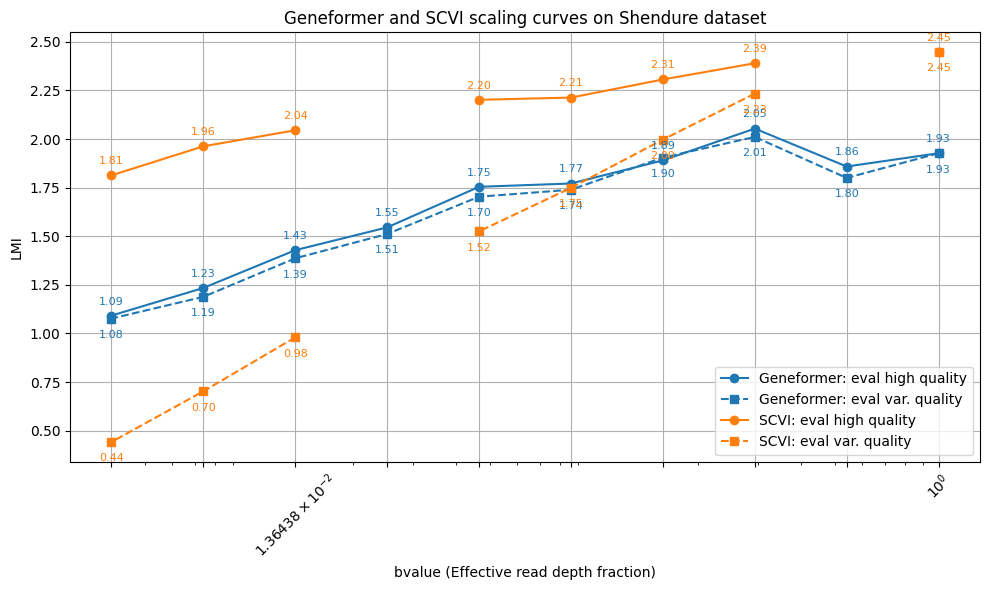

In [23]:
import matplotlib.pyplot as plt

# Only select rows for shendure, just in case we have more datasets in the future
df = merged_df[merged_df['dataset'] == 'shendure'].copy()

# For plotting, ensure the bvalue is sorted descending (from 1.0 to low)
df = df.sort_values('bvalue', ascending=False)

# Convert None and missing/NaN to np.nan for plotting
def safe_float(x):
    try:
        if x is None:
            return float('nan')
        return float(x)
    except Exception:
        return float('nan')

df['lmi_new_high_quality_eval'] = df['lmi_new_high_quality_eval'].apply(safe_float)
df['lmi_original_same_quality_eval'] = df['lmi_original_same_quality_eval'].apply(safe_float)

# Separate dataframes for each algorithm for easier plotting and annotation
df_geneformer = df[df['algorithm'] == 'Geneformer']
df_scvi = df[df['algorithm'] == 'SCVI']

plt.figure(figsize=(10, 6))

# Define colors manually for algorithm consistency
geneformer_color = "#1f77b4"  # matplotlib default blue
scvi_color = "#ff7f0e"        # matplotlib default orange

# Geneformer
plt.plot(df_geneformer['bvalue'], df_geneformer['lmi_new_high_quality_eval'],
         marker='o', linestyle='-', color=geneformer_color, label='Geneformer: eval high quality')
plt.plot(df_geneformer['bvalue'], df_geneformer['lmi_original_same_quality_eval'],
         marker='s', linestyle='--', color=geneformer_color, label='Geneformer: eval var. quality')

# SCVI
plt.plot(df_scvi['bvalue'], df_scvi['lmi_new_high_quality_eval'],
         marker='o', linestyle='-', color=scvi_color, label='SCVI: eval high quality')
plt.plot(df_scvi['bvalue'], df_scvi['lmi_original_same_quality_eval'],
         marker='s', linestyle='--', color=scvi_color, label='SCVI: eval var. quality')

# Add value annotation for each point, using corresponding line color and rounded to 2 decimals
for i, (x, y) in enumerate(zip(df_geneformer['bvalue'], df_geneformer['lmi_new_high_quality_eval'])):
    if not pd.isna(y):
        plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8),
                     ha='center', color=geneformer_color, fontsize=8)
for i, (x, y) in enumerate(zip(df_geneformer['bvalue'], df_geneformer['lmi_original_same_quality_eval'])):
    if not pd.isna(y):
        plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,-14),
                     ha='center', color=geneformer_color, fontsize=8)

for i, (x, y) in enumerate(zip(df_scvi['bvalue'], df_scvi['lmi_new_high_quality_eval'])):
    if not pd.isna(y):
        plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8),
                     ha='center', color=scvi_color, fontsize=8)
for i, (x, y) in enumerate(zip(df_scvi['bvalue'], df_scvi['lmi_original_same_quality_eval'])):
    if not pd.isna(y):
        plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,-14),
                     ha='center', color=scvi_color, fontsize=8)

plt.xlabel('bvalue (Effective read depth fraction)')
plt.ylabel('LMI')
plt.title('Geneformer and SCVI scaling curves on Shendure dataset')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.xticks(df['bvalue'].unique(), rotation=45)
plt.tight_layout()
plt.show()
